In [5]:
import lucem_illud as li

import os #For managing the operating system
import requests #For getting files
import zipfile #For managing zips
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas as pd #Gives us DataFrames
import numpy as np #Math and matrices
import matplotlib.pyplot as plt #For graphics

# statsmodels is a popular Python statistics package
import statsmodels.api as sm
# Let's also import its graphics module
import statsmodels.graphics.api as smg
# And the mediation module
from statsmodels.stats.mediation import Mediation

# Pipelines to add text-based quantiative variables for regressions
from transformers import pipeline

# We have a lot of features, so let's set Pandas to show all of them.
pd.set_option('display.max_columns', None)

#my personal module
import incels
import ast

Loading the data that includes sentiment...

In [3]:
main_df = incels.csv_loader('main_detailed.csv')

In [6]:
main_df['slang'] = main_df['slang'].fillna('[]')
main_df['slang'] = main_df['slang'].apply(lambda x: ast.literal_eval(x))

In [36]:
simple_df = main_df[['post_id', 'thread_title', 'thread_tag', 'thread_author', 'number_responses', 'thread_time', 'comment_id', 'username', 'raw_text', 'slang', 'sentiment_polarity']]

In [60]:
parent_df = simple_df[simple_df['comment_id'] == 0]
parent_df = parent_df[parent_df['number_responses'] > 1]
child_df = simple_df[simple_df['comment_id'] != 0]

Creating a triples dataframe of a top level comment and the first 2 responses

In [61]:
parent_df['slang_r1'] = 0
parent_df['slang_r2'] = 0
parent_df['sentiment_polarity_r1'] = 0
parent_df['sentiment_polarity_r2'] = 0
for row in parent_df.iterrows():
    # row[0]['slang_r1'] = child_df['slang'][child_df['post_id'] == row[1]['post_id']]
    # print(row[1]['number_responses'])
    child_row_1 = child_df[child_df['post_id'] == row[1]['post_id']].iloc[0]
    # row[1]['slang_r1'] = child_row_1['slang']
    parent_df
    row[1]['sentiment_polarity_r1'] = child_row_1['sentiment_polarity']
    child_row_2 = child_df[child_df['post_id'] == child_row_1['post_id']].iloc[1]
    row[1]['slang_r2'] = child_row_2['slang']
    row[1]['sentiment_polarity_r2'] = child_row_2['sentiment_polarity']

    # for child in child_df[child_df['post_id'] == row[1]['post_id']].iterrows():
    #     row[0]['slang_r1'] += child[1]['slang']

In [66]:
def doChildren(row):
    row['slang_r1'] = child_df['slang'][child_df['post_id'] == row['post_id']].iloc[0]
    row['slang_r2'] = child_df['slang'][child_df['post_id'] == row['post_id']].iloc[1]
    row['raw_text_r1'] = child_df['raw_text'][child_df['post_id'] == row['post_id']].iloc[0]
    row['raw_text_r2'] = child_df['raw_text'][child_df['post_id'] == row['post_id']].iloc[1]
    row['sentiment_polarity_r1'] = child_df['sentiment_polarity'][child_df['post_id'] == row['post_id']].iloc[0]
    row['sentiment_polarity_r2'] = child_df['sentiment_polarity'][child_df['post_id'] == row['post_id']].iloc[1]
    return row

parent_df = parent_df.apply(doChildren, axis=1)

In [52]:
child_df[child_df['post_id'] == 3].iloc[0]

post_id                                                             3.0
thread_title          Getting 6’7” aryan gigachad to sneak a 5’2” et...
thread_tag                                                 [Experiment]
thread_author                                          SchrodingersDick
number_responses                                                    NaN
thread_time                                         2018-10-16 01:46:42
comment_id                                                          1.0
username                                                          Zesto
raw_text              Yes those western whores would deserve it.\n\n...
slang                                                                []
sentiment_polarity                                            -0.982668
Name: main_3_1, dtype: object

In [64]:
#rename slang to slang_parent
parent_df['slang_parent'] = parent_df['slang']
parent_df['sentiment_polarity_parent'] = parent_df['sentiment_polarity']

Use sentence tokanization in order to process the text of the comments for sentiment analysis better

In [68]:
parent_df['sent_token_parent'] = parent_df['raw_text'].apply(lambda x: li.sent_tokenize(x))
parent_df['sent_token_r1'] = parent_df['raw_text_r1'].apply(lambda x: li.sent_tokenize(x))
parent_df['sent_token_r2'] = parent_df['raw_text_r2'].apply(lambda x: li.sent_tokenize(x))

In [70]:
nlp = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [71]:
def create_sentiments(sent_tokens):
    sentiments = []
    for sent in sent_tokens:
        result = nlp(sent)[0]
        sentiments.append((result['label'], result['score']))
    return sentiments

In [72]:
parent_df['sentiments_parent'] = parent_df['sent_token_parent'].apply(create_sentiments)
parent_df['sentiments_r1'] = parent_df['sent_token_r1'].apply(create_sentiments)
parent_df['sentiments_r2'] = parent_df['sent_token_r2'].apply(create_sentiments)

In [73]:
parent_df

,post_id,thread_title,thread_tag,thread_author,number_responses,thread_time,comment_id,username,raw_text,slang,sentiment_polarity,slang_r1,slang_r2,sentiment_polarity_r1,sentiment_polarity_r2,slang_parent,sentiment_polarity_parent,raw_text_r1,raw_text_r2,sent_token_parent,sent_token_r1,sent_token_r2,sentiments_parent,sentiments_r1,sentiments_r2
id,,,,,,,,,,,,,,,,,,,,,,,,,
main_2_0,2.0,My arms are so small,[SuicideFuel],MaxZM98,15.0,2018-10-17 13:38:33,0.0,MaxZM98,I was looking at myself in the gym mirror and ...,[],-0.505297,[],[bbc],-0.505297,-0.505297,[],-0.505297,"You, have a shitty training plan or shitty mea...","I bet you're white, huge muscles and big arms ...",[I was looking at myself in the gym mirror and...,"[You, have a shitty training plan or shitty me...","[I bet you're white, huge muscles and big arms...","[(NEGATIVE, 0.9996656179428101), (NEGATIVE, 0....","[(NEGATIVE, 0.9997606873512268), (POSITIVE, 0....","[(NEGATIVE, 0.9516608715057373)]"
main_3_0,3.0,Getting 6’7” aryan gigachad to sneak a 5’2” et...,[Experiment],SchrodingersDick,37.0,2018-10-16 01:46:42,0.0,SchrodingersDick,If there any sperm banks that disclose the man...,"[gigachad, truecel, chad, blackpill]",-0.982668,[],[],-0.982668,-0.982668,"[gigachad, truecel, chad, blackpill]",-0.982668,Yes those western whores would deserve it.\n\n...,Perfect plan.,[If there any sperm banks that disclose the ma...,"[Yes those western whores would deserve it., R...",[Perfect plan.],"[(NEGATIVE, 0.9989012479782104), (NEGATIVE, 0....","[(NEGATIVE, 0.987155556678772), (POSITIVE, 0.9...","[(POSITIVE, 0.9998689889907837)]"
main_4_0,4.0,7'2 Giga Chad - The Man Who Mogs Every Human i...,[SuicideFuel],rabitter,61.0,2018-10-17 09:22:55,0.0,rabitter,The fact that a man like this exists is unfilt...,"[suifuel, mogging, chad]",0.591624,[],[],0.591624,0.591624,"[suifuel, mogging, chad]",0.591624,I would kill everyone on earth to become this ...,"The 5'11"" dude mogs him.",[The fact that a man like this exists is unfil...,[I would kill everyone on earth to become this...,"[The 5'11"" dude mogs him.]","[(NEGATIVE, 0.9967505931854248), (NEGATIVE, 0....","[(NEGATIVE, 0.9713948965072632)]","[(NEGATIVE, 0.9817057847976685)]"
main_5_0,5.0,There's no way winning against your schoolbull...,[Venting],Doug,34.0,2018-10-17 07:52:30,0.0,Doug,"If you beat him up, you gonna get smacked by h...",[incel],-0.999204,[],[],-0.999204,-0.999204,[incel],-0.999204,Doug said:\n\n\n\nIf you tell the teachers tha...,I never got bullied in school if someone ever ...,"[If you beat him up, you gonna get smacked by ...",[Doug said:\n\n\n\nIf you tell the teachers th...,[I never got bullied in school if someone ever...,"[(NEGATIVE, 0.9991975426673889)]","[(NEGATIVE, 0.9268738627433777), (NEGATIVE, 0....","[(NEGATIVE, 0.9703671932220459), (NEGATIVE, 0...."
main_6_0,6.0,Do you approach or given up already?,[Experiment],itsmemario,39.0,2018-10-17 13:33:48,0.0,itsmemario,title,[],-0.986872,[],[],-0.986872,-0.986872,[],-0.986872,Never approached tbh,I tried for years and gave up after getting my...,[title],[Never approached tbh],[I tried for years and gave up after getting m...,"[(POSITIVE, 0.9987114667892456)]","[(NEGATIVE, 0.9784131646156311)]","[(NEGATIVE, 0.9992914199829102)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
main_597_0,597.0,Sometimes ugly guys get women by winning them ...,NaN,FemaleInventionsLOL,9.0,2018-12-01 05:12:04,0.0,FemaleInventionsLOL,Ugly guys like BRAD PITT: https://answers.yaho...,[brad],-0.690282,[],[],-0.690282,-0.690282,[brad],-0.690282,based sat post,meme gender,[Ugly guys like BRAD PITT: https://answers.yah...,[based sat post],[meme gender],"[(NEGATIVE, 0.9974476099014282), (NEGATIVE, 0....","[(NEGATIVE, 0.5766851305961609)]","[(POSITIVE, 0.9292739629745483)]"
main_598_0,598.0,Family adopts a live-in braindead BBC bull,[JFL],CyborgIncel,134.0,2018-09-11 17:27:59,0.0,CyborgIncel,Just look at the way his sister looks at him. .

In [74]:
def average_sentiment(sentiments):
    polarities = []
    for sentiment in sentiments:
        if sentiment[0] == 'POSITIVE':
            polarities.append(sentiment[1])
        elif sentiment[0] == 'NEGATIVE':
            polarities.append(-1 * sentiment[1])
    
    if len(polarities) == 0:
        return 0
    else:
        return np.mean(polarities)

In [75]:
parent_df['avg_sentiment_parent'] = parent_df['sentiments_parent'].apply(average_sentiment)
parent_df['avg_sentiment_r1'] = parent_df['sentiments_r1'].apply(average_sentiment)
parent_df['avg_sentiment_r2'] = parent_df['sentiments_r2'].apply(average_sentiment)

In [108]:
parent_df

,post_id,thread_title,thread_tag,thread_author,number_responses,thread_time,comment_id,username,raw_text,slang,sentiment_polarity,slang_r1,slang_r2,sentiment_polarity_r1,sentiment_polarity_r2,slang_parent,sentiment_polarity_parent,raw_text_r1,raw_text_r2,sent_token_parent,sent_token_r1,sent_token_r2,sentiments_parent,sentiments_r1,sentiments_r2,avg_sentiment_parent,avg_sentiment_r1,avg_sentiment_r2,tag,slang_count_parent,slang_count_r1,slang_count_r2,comment_length_parent,comment_length_r1,comment_length_r2,slang_count_ratio_parent,slang_count_ratio_r1,slang_count_ratio_r2
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
main_2_0,2.0,My arms are so small,[SuicideFuel],MaxZM98,15.0,2018-10-17 13:38:33,0.0,MaxZM98,I was looking at myself in the gym mirror and ...,[],-0.505297,[],[bbc],-0.505297,-0.505297,[],-0.505297,"You, have a shitty training plan or shitty mea...","I bet you're white, huge muscles and big arms ...",[I was looking at myself in the gym mirror and...,"[You, have a shitty training plan or shitty me...","[I bet you're white, huge muscles and big arms...","[(NEGATIVE, 0.9996656179428101), (NEGATIVE, 0....","[(NEGATIVE, 0.9997606873512268), (POSITIVE, 0....","[(NEGATIVE, 0.9516608715057373)]",-0.999140,0.331654,-0.951661,2,0,0,1,204,190,72,0.000000,0.000000,0.013889
main_3_0,3.0,Getting 6’7” aryan gigachad to sneak a 5’2” et...,[Experiment],SchrodingersDick,37.0,2018-10-16 01:46:42,0.0,SchrodingersDick,If there any sperm banks that disclose the man...,"[gigachad, truecel, chad, blackpill]",-0.982668,[],[],-0.982668,-0.982668,"[gigachad, truecel, chad, blackpill]",-0.982668,Yes those western whores would deserve it.\n\n...,Perfect plan.,[If there any sperm banks that disclose the ma...,"[Yes those western whores would deserve it., R...",[Perfect plan.],"[(NEGATIVE, 0.9989012479782104), (NEGATIVE, 0....","[(NEGATIVE, 0.987155556678772), (POSITIVE, 0.9...","[(POSITIVE, 0.9998689889907837)]",-0.675815,-0.321426,0.999869,3,4,0,0,754,156,13,0.005305,0.000000,0.000000
main_4_0,4.0,7'2 Giga Chad - The Man Who Mogs Every Human i...,[SuicideFuel],rabitter,61.0,2018-10-17 09:22:55,0.0,rabitter,The fact that a man like this exists is unfilt...,"[suifuel, mogging, chad]",0.591624,[],[],0.591624,0.591624,"[suifuel, mogging, chad]",0.591624,I would kill everyone on earth to become this ...,"The 5'11"" dude mogs him.",[The fact that a man like this exists is unfil...,[I would kill everyone on earth to become this...,"[The 5'11"" dude mogs him.]","[(NEGATIVE, 0.9967505931854248), (NEGATIVE, 0....","[(NEGATIVE, 0.9713948965072632)]","[(NEGATIVE, 0.9817057847976685)]",-0.593388,-0.971395,-0.981706,2,3,0,0,262,50,24,0.011450,0.000000,0.000000
main_5_0,5.0,There's no way winning against your schoolbull...,[Venting],Doug,34.0,2018-10-17 07:52:30,0.0,Doug,"If you beat him up, you gonna get smacked by h...",[incel],-0.999204,[],[],-0.999204,-0.999204,[incel],-0.999204,Doug said:\n\n\n\nIf you tell the teachers tha...,I never got bullied in school if someone ever ...,"[If you beat him up, you gonna get smacked by ...",[Doug said:\n\n\n\nIf you tell the teachers th...,[I never got bullied in school if someone ever...,"[(NEGATIVE, 0.9991975426673889)]","[(NEGATIVE, 0.9268738627433777), (NEGATIVE, 0....","[(NEGATIVE, 0.9703671932220459), (NEGATIVE, 0....",-0.999198,-0.955697,-0.978905,4,1,0,0,541,190,218,0.001848,0.000000,0.000000
main_6_0,6.0,Do you approach or given up already?,[Experiment],itsmemario,39.0,2018-10-17 13:33:48,0.0,itsmemario,title,[],-0.986872,[],[],-0.986872,-0.986872,[],-0.986872,Never approached tbh,I tried for years and gave up after getting my...,[title],[Never approached tbh],[I tried for years and gave up after getting m...,"[(POSITIVE, 0.9987114667892456)]","[(NEGATIVE, 0.9784131646156311)]","[(NEGATIVE, 0.9992914199829102)]",0.998711,-0.978413,-0.999291,3,0,0,0,5,20,75,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

Making an enum to make dealing with using the tags for regression easier

In [88]:
import enum
from enum import Enum, auto
class ForumTag(Enum):
    NONE = auto()
    SUICIDEFUEL = auto()
    EXPERIMENT = auto()
    VENTING = auto()
    RAGEFUEL = auto()
    BLACKPILL = auto()
    JFL = auto()
    STORY = auto()
    SERIOUS = auto()
    HYPOCRISY = auto()
    LIFEFUEL = auto()
    TEEHEE = auto()
    ITOVER = auto()
    SOY = auto()
    NEWS = auto()
    LDAR = auto()
    NSFW = auto()

Converting tags to a numeric value

In [96]:
def prepare_tag(tag):
    if tag == np.nan:
        return ForumTag.NONE 
    tag = tag.replace('[', '').replace(']', '').replace(' ', '').replace("'s","")
    return ForumTag[tag.upper()].value

In [93]:
# parent_df['thread_tag'] = parent_df['thread_tag']

In [97]:
parent_df['tag'] = parent_df['thread_tag'].fillna('NONE').apply(prepare_tag)

In [103]:
parent_df['slang_count_parent'] = parent_df['slang_parent'].apply(lambda x: len(x))
parent_df['slang_count_r1'] = parent_df['slang_r1'].apply(lambda x: len(x))
parent_df['slang_count_r2'] = parent_df['slang_r2'].apply(lambda x: len(x))

In [107]:
parent_df['comment_length_parent'] = parent_df['raw_text'].apply(lambda x: len(x))
parent_df['comment_length_r1'] = parent_df['raw_text_r1'].apply(lambda x: len(x))
parent_df['comment_length_r2'] = parent_df['raw_text_r2'].apply(lambda x: len(x))
parent_df['slang_count_ratio_parent'] = parent_df['slang_count_parent'] / parent_df['comment_length_parent']
parent_df['slang_count_ratio_r1'] = parent_df['slang_count_r1'] / parent_df['comment_length_r1']
parent_df['slang_count_ratio_r2'] = parent_df['slang_count_r2'] / parent_df['comment_length_r2']

In [98]:
parent_df['tag']

id
main_2_0      2
main_3_0      3
main_4_0      2
main_5_0      4
main_6_0      3
             ..
main_597_0    1
main_598_0    7
main_599_0    2
main_600_0    2
main_601_0    1
Name: tag, Length: 451, dtype: int64

In [145]:
parent_df['avg_sentiment_abs_parent'] = parent_df['avg_sentiment_parent'].apply(lambda x: abs(x))
parent_df['avg_sentiment_abs_r1'] = parent_df['avg_sentiment_r1'].apply(lambda x: abs(x))
parent_df['avg_sentiment_abs_r2'] = parent_df['avg_sentiment_r2'].apply(lambda x: abs(x))

In [210]:
parent_df.columns

Index(['post_id', 'thread_title', 'thread_tag', 'thread_author',
       'number_responses', 'thread_time', 'comment_id', 'username', 'raw_text',
       'slang', 'sentiment_polarity', 'slang_r1', 'slang_r2',
       'sentiment_polarity_r1', 'sentiment_polarity_r2', 'slang_parent',
       'sentiment_polarity_parent', 'raw_text_r1', 'raw_text_r2',
       'sent_token_parent', 'sent_token_r1', 'sent_token_r2',
       'sentiments_parent', 'sentiments_r1', 'sentiments_r2',
       'avg_sentiment_parent', 'avg_sentiment_r1', 'avg_sentiment_r2', 'tag',
       'slang_count_parent', 'slang_count_r1', 'slang_count_r2',
       'comment_length_parent', 'comment_length_r1', 'comment_length_r2',
       'slang_count_ratio_parent', 'slang_count_ratio_r1',
       'slang_count_ratio_r2', 'avg_sentiment_abs_parent',
       'avg_sentiment_abs_r1', 'avg_sentiment_abs_r2'],
      dtype='object')

Regression has some interesting results but the P>|t| is not significant

In [211]:
y = parent_df['number_responses']
# X_cols = ['avg_sentiment_abs_parent', 'avg_sentiment_abs_r1', 'avg_sentiment_abs_r2']
X_cols = ['sentiment_polarity', 'avg_sentiment_abs_parent']
X = sm.add_constant(parent_df[X_cols])

lm2 = sm.OLS(y, X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       number_responses   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.578
Date:                Thu, 17 Mar 2022   Prob (F-statistic):              0.207
Time:                        21:49:41   Log-Likelihood:                -2808.8
No. Observations:                 451   AIC:                             5624.
Df Residuals:                     448   BIC:                             5636.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       25.5832     11.731      2.181      0.030       2.528      48.638
sentiment_polarity          10.5900      7.133      1.485      0.138      -3.428      24.609
avg_sentiment_abs_parent    19.2368     16.517      1.165      0.245     -13.224      51.697
==============================================================================
Omnibus:                     1068.556   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3223863.303
Skew:                          19.970   Prob(JB):                         0.00
Kurtosis:                     415.266   Cond. No.                         4.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

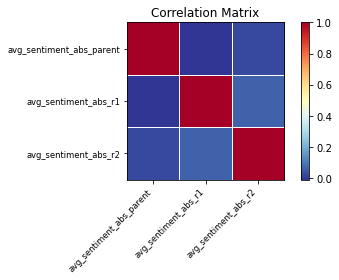

In [151]:
corr_matrix = np.corrcoef(parent_df[X_cols].T)
smg.plot_corr(corr_matrix, xnames=X_cols)
plt.show()

Again there's some interesting stuff but nothing significant as far as I can tell

In [152]:
y = parent_df['number_responses']
X_cols = ['avg_sentiment_parent', 'slang_count_parent', 'avg_sentiment_r1', 'slang_count_r1', 'avg_sentiment_r2', 'slang_count_r2', 'tag']
X = sm.add_constant(parent_df[X_cols])

lm2 = sm.OLS(y, X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       number_responses   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.956
Date:                Wed, 16 Mar 2022   Prob (F-statistic):             0.0596
Time:                        17:04:41   Log-Likelihood:                -2803.5
No. Observations:                 451   AIC:                             5623.
Df Residuals:                     443   BIC:                             5656.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.8934     12.567      1.026      0.305     -11.806      37.593
avg_sentiment_parent    -7.0391     11.234     -0.627      0.531     -29.118      15.040
slang_count_parent      -1.5121      2.684     -0.563      0.573      -6.787       3.763
avg_sentiment_r1        -8.2787      7.204     -1.149      0.251     -22.437       5.880
slang_count_r1          10.1490      9.989      1.016      0.310      -9.483      29.781
avg_sentiment_r2        14.0717      7.656      1.838      0.067      -0.974      29.118
slang_count_r2          20.2288      8.928      2.266      0.024       2.682      37.775
tag                      1.7205      1.345      1.279      0.202      -0.923       4.364
==============================================================================
Omnibus:                     1052.875   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2944298.872
Skew:                          19.297   Prob(JB):                         0.00
Kurtosis:                     396.944   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

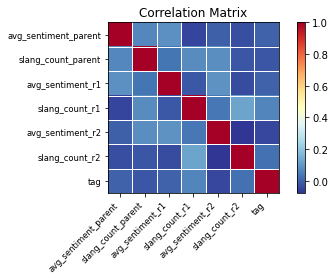

In [153]:
corr_matrix = np.corrcoef(parent_df[X_cols].T)
smg.plot_corr(corr_matrix, xnames=X_cols)
plt.show()

Interesting that the average sentiment of the parent has such a high P>|t| for such a low t for correlation with the length of the second response. Not sure what to make of that

In [141]:
y = parent_df['comment_length_r2']
X_cols = ['avg_sentiment_parent', 'slang_count_parent', 'avg_sentiment_r1', 'slang_count_r1']
X = sm.add_constant(parent_df[X_cols])

lm2 = sm.OLS(y, X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      comment_length_r2   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.5112
Date:                Wed, 16 Mar 2022   Prob (F-statistic):              0.728
Time:                        15:12:17   Log-Likelihood:                -2918.0
No. Observations:                 451   AIC:                             5846.
Df Residuals:                     446   BIC:                             5867.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  122.1414     11.845     10.311      0.000      98.862     145.421
avg_sentiment_parent     0.7653     14.426      0.053      0.958     -27.586      29.116
slang_count_parent       2.6118      3.437      0.760      0.448      -4.143       9.366
avg_sentiment_r1        10.4426      9.214      1.133      0.258      -7.665      28.551
slang_count_r1           3.2639     12.699      0.257      0.797     -21.694      28.222
==============================================================================
Omnibus:                      383.783   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7408.002
Skew:                           3.690   Prob(JB):                         0.00
Kurtosis:                      21.432   Cond. No.                         5.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

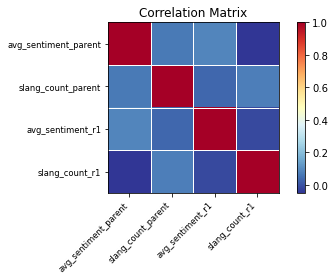

In [142]:
corr_matrix = np.corrcoef(parent_df[X_cols].T)
smg.plot_corr(corr_matrix, xnames=X_cols)
plt.show()

While it is only 0.76 P>|t|, it is interesting that the correlation is negative

In [144]:
y = parent_df['avg_sentiment_r2']
X_cols = ['avg_sentiment_parent', 'slang_count_ratio_parent', 'avg_sentiment_r1', 'slang_count_ratio_r1']
X = sm.add_constant(parent_df[X_cols])

lm2 = sm.OLS(y, X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       avg_sentiment_r2   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.520
Date:                Wed, 16 Mar 2022   Prob (F-statistic):             0.0406
Time:                        15:16:21   Log-Likelihood:                -511.68
No. Observations:                 451   AIC:                             1033.
Df Residuals:                     446   BIC:                             1054.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.3922      0.054     -7.326      0.000      -0.497      -0.287
avg_sentiment_parent        -0.0205      0.069     -0.295      0.768      -0.157       0.116
slang_count_ratio_parent    12.8294      5.110      2.510      0.012       2.786      22.873
avg_sentiment_r1             0.0893      0.045      2.005      0.046       0.002       0.177
slang_count_ratio_r1        -0.4874      1.739     -0.280      0.779      -3.904       2.930
==============================================================================
Omnibus:                       83.300   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.720
Skew:                           0.818   Prob(JB):                     1.46e-14
Kurtosis:                       2.156   Cond. No.                         179.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [165]:
def get_row_by_ids(post_id, comment_id):
    return main_df[(main_df['post_id'] == post_id) & (main_df['comment_id'] == comment_id)]

In [169]:
topic_df = parent_df.copy()

In [193]:
topic_df['topic_0_parent'] = topic_df.apply(lambda x: get_row_by_ids(x['post_id'], x['comment_id']).iloc[0]['topic_0'], axis=1)
topic_df['topic_1_parent'] = topic_df.apply(lambda x: get_row_by_ids(x['post_id'], x['comment_id']).iloc[0]['topic_1'], axis=1)
topic_df['topic_2_parent'] = topic_df.apply(lambda x: get_row_by_ids(x['post_id'], x['comment_id']).iloc[0]['topic_2'], axis=1)
topic_df['topic_3_parent'] = topic_df.apply(lambda x: get_row_by_ids(x['post_id'], x['comment_id']).iloc[0]['topic_3'], axis=1)
topic_df['topic_4_parent'] = topic_df.apply(lambda x: get_row_by_ids(x['post_id'], x['comment_id']).iloc[0]['topic_4'], axis=1)

In [194]:
# topic_df['unique_id_r1'] = topic_df.apply(lambda x: get_row_by_ids(x['post_id'], x['comment_id_r1']).iloc[0].index, axis=1)

In [168]:
topic_df

,post_id,thread_title,thread_tag,thread_author,number_responses,thread_time,comment_id,username,raw_text,slang,sentiment_polarity,slang_r1,slang_r2,sentiment_polarity_r1,sentiment_polarity_r2,slang_parent,sentiment_polarity_parent,raw_text_r1,raw_text_r2,sent_token_parent,sent_token_r1,sent_token_r2,sentiments_parent,sentiments_r1,sentiments_r2,avg_sentiment_parent,avg_sentiment_r1,avg_sentiment_r2,tag,slang_count_parent,slang_count_r1,slang_count_r2,comment_length_parent,comment_length_r1,comment_length_r2,slang_count_ratio_parent,slang_count_ratio_r1,slang_count_ratio_r2,avg_sentiment_abs_parent,avg_sentiment_abs_r1,avg_sentiment_abs_r2,topic_0
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
main_2_0,2.0,My arms are so small,[SuicideFuel],MaxZM98,15.0,2018-10-17 13:38:33,0.0,MaxZM98,I was looking at myself in the gym mirror and ...,[],-0.505297,[],[bbc],-0.505297,-0.505297,[],-0.505297,"You, have a shitty training plan or shitty mea...","I bet you're white, huge muscles and big arms ...",[I was looking at myself in the gym mirror and...,"[You, have a shitty training plan or shitty me...","[I bet you're white, huge muscles and big arms...","[(NEGATIVE, 0.9996656179428101), (NEGATIVE, 0....","[(NEGATIVE, 0.9997606873512268), (POSITIVE, 0....","[(NEGATIVE, 0.9516608715057373)]",-0.999140,0.331654,-0.951661,2,0,0,1,204,190,72,0.000000,0.000000,0.013889,0.999140,0.331654,0.951661,0.013247
main_3_0,3.0,Getting 6’7” aryan gigachad to sneak a 5’2” et...,[Experiment],SchrodingersDick,37.0,2018-10-16 01:46:42,0.0,SchrodingersDick,If there any sperm banks that disclose the man...,"[gigachad, truecel, chad, blackpill]",-0.982668,[],[],-0.982668,-0.982668,"[gigachad, truecel, chad, blackpill]",-0.982668,Yes those western whores would deserve it.\n\n...,Perfect plan.,[If there any sperm banks that disclose the ma...,"[Yes those western whores would deserve it., R...",[Perfect plan.],"[(NEGATIVE, 0.9989012479782104), (NEGATIVE, 0....","[(NEGATIVE, 0.987155556678772), (POSITIVE, 0.9...","[(POSITIVE, 0.9998689889907837)]",-0.675815,-0.321426,0.999869,3,4,0,0,754,156,13,0.005305,0.000000,0.000000,0.675815,0.321426,0.999869,0.133183
main_4_0,4.0,7'2 Giga Chad - The Man Who Mogs Every Human i...,[SuicideFuel],rabitter,61.0,2018-10-17 09:22:55,0.0,rabitter,The fact that a man like this exists is unfilt...,"[suifuel, mogging, chad]",0.591624,[],[],0.591624,0.591624,"[suifuel, mogging, chad]",0.591624,I would kill everyone on earth to become this ...,"The 5'11"" dude mogs him.",[The fact that a man like this exists is unfil...,[I would kill everyone on earth to become this...,"[The 5'11"" dude mogs him.]","[(NEGATIVE, 0.9967505931854248), (NEGATIVE, 0....","[(NEGATIVE, 0.9713948965072632)]","[(NEGATIVE, 0.9817057847976685)]",-0.593388,-0.971395,-0.981706,2,3,0,0,262,50,24,0.011450,0.000000,0.000000,0.593388,0.971395,0.981706,0.012100
main_5_0,5.0,There's no way winning against your schoolbull...,[Venting],Doug,34.0,2018-10-17 07:52:30,0.0,Doug,"If you beat him up, you gonna get smacked by h...",[incel],-0.999204,[],[],-0.999204,-0.999204,[incel],-0.999204,Doug said:\n\n\n\nIf you tell the teachers tha...,I never got bullied in school if someone ever ...,"[If you beat him up, you gonna get smacked by ...",[Doug said:\n\n\n\nIf you tell the teachers th...,[I never got bullied in school if someone ever...,"[(NEGATIVE, 0.9991975426673889)]","[(NEGATIVE, 0.9268738627433777), (NEGATIVE, 0....","[(NEGATIVE, 0.9703671932220459), (NEGATIVE, 0....",-0.999198,-0.955697,-0.978905,4,1,0,0,541,190,218,0.001848,0.000000,0.000000,0.999198,0.955697,0.978905,0.000000
main_6_0,6.0,Do you approach or given up already?,[Experiment],itsmemario,39.0,2018-10-17 13:33:48,0.0,itsmemario,title,[],-0.986872,[],[],-0.986872,-0.986872,[],-0.986872,Never approached tbh,I tried for years and gave up after getting my...,[title],[Never approached tbh],[I tried for years and gave up after getting m...,"[(POSITIVE, 0.9987114667892456)]","[(NEGATIVE, 0.9784131646156311)]","[(NEGATIVE, 0

Incorporating the topic model results, not much

In [207]:
y = topic_df['number_responses']
X_cols = ['topic_0_parent', 'topic_1_parent', 'topic_2_parent', 'topic_3_parent', 'topic_4_parent']
X = sm.add_constant(topic_df[X_cols])

lm2 = sm.OLS(y, X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       number_responses   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.957
Date:                Wed, 16 Mar 2022   Prob (F-statistic):             0.0122
Time:                        17:32:18   Log-Likelihood:                -2803.0
No. Observations:                 451   AIC:                             5618.
Df Residuals:                     445   BIC:                             5643.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -548.7021    909.851     -0.603      0.547   -2336.842    1239.437
topic_0_parent   576.8687    914.447      0.631      0.528   -1220.303    2374.040
topic_1_parent   566.2991    914.424      0.619      0.536   -1230.827    2363.425
topic_2_parent   677.9879    913.869      0.742      0.459   -1118.048    2474.024
topic_3_parent   568.0892    915.923      0.620      0.535   -1231.982    2368.160
topic_4_parent   574.1893    914.349      0.628      0.530   -1222.789    2371.167
==============================================================================
Omnibus:                     1050.050   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2899187.995
Skew:                          19.177   Prob(JB):                         0.00
Kurtosis:                     393.908   Cond. No.                         430.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

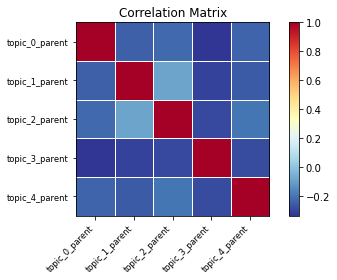

In [203]:
corr_matrix = np.corrcoef(topic_df[X_cols].T)
smg.plot_corr(corr_matrix, xnames=X_cols)
plt.show()